# What Happens When Gradient is Zero?

In [2]:
### Import libraries
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

/tmp/ipykernel_2743747/4147228706.py:8: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print("Device", device)

Device cuda


In [4]:
def fn(x):
    return torch.sin(5*torch.pi*x)/(5*torch.pi*x)

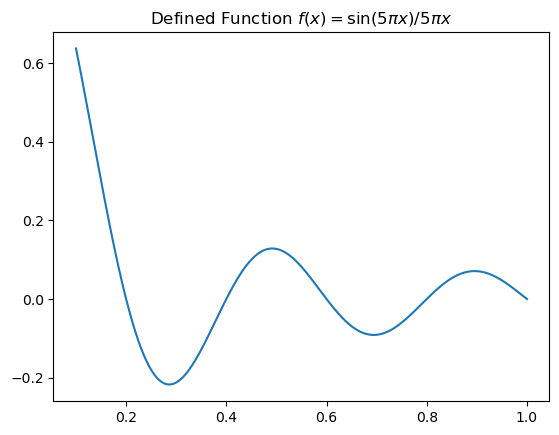

In [6]:
### Plot fn
xvec = torch.linspace(0.1,1,1000)
yvec = fn(xvec)
plt.plot(xvec,yvec, label = "function")
plt.title("Defined Function $f(x)=\sin(5\pi x)/5\pi x$")
plt.show()

In [7]:
class model_class_fn(nn.Module):
    def __init__(self, input_size, output_size, hidden_sizes=None):
        super(model_class_fn, self).__init__()

        # Store model architecture parameters
        self.input_size = input_size
        self.output_size = output_size
        self.hidden_sizes = hidden_sizes or []

        # Create layers
        layers = []
        in_features = input_size
        for h_size in hidden_sizes:
            layers.append(nn.Linear(in_features, h_size))
            layers.append(nn.ReLU())  # Add activation after each hidden layer
            in_features = h_size
        layers.append(nn.Linear(in_features, output_size))
        self.layers = nn.ModuleList(layers)

    def forward(self, x):
        # Forward pass through the layers
        for layer in self.layers:
            x = layer(x)
        return x

In [9]:
def gradient_norm(model):
    grad_all = 0.0
    for p in model.parameters():
        grad = 0.0 
        if p.grad is not None:
            grad = (p.grad.cpu().data.numpy() ** 2).sum()
        grad_all += grad

    grad_norm = grad_all ** 0.5
    return grad_norm

In [41]:
### Training function for training on fn(x)
def train_model(model, X_train, Y_train, batch, epochs, learning_rate):

  # send data to device
  X_train, Y_train = X_train.to(device), Y_train.to(device)

  # load training data for model 1
  data_loader = DataLoader(TensorDataset(X_train,Y_train), batch_size=batch, shuffle = True)

  # Create optimizer and loss function
  optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate)
  loss_fn = nn.MSELoss()
  
  # Send model to device
  model.to(device)

  # Training loop for model 1
  loss_vec = []
  gradient = []
  grad_min = np.inf
  for epoch in range(epochs):
      epoch_loss = 0.0
      for i,data in enumerate(data_loader):
          x_batch, y_batch = data
          optimizer.zero_grad()
      #print(x_train.shape)
          y_pred = model(x_batch)
          loss = loss_fn(y_pred, y_batch)
          loss.backward()
          optimizer.step()
          epoch_loss += loss.item()
      epoch_loss = epoch_loss/len(data_loader.sampler)
      if epoch % 10 == 0:
         print(f"Epoch: {epoch}; loss: {epoch_loss}")
      loss_vec.append(epoch_loss)
      gradient.append(gradient_norm(model))
      if gradient[-1] < grad_min:
         grad_min = gradient[-1]
  return loss_vec, gradient, grad_min

In [ ]:
for name, parameter in model.named_parameters():
        if 'weight' in name:
                weights = torch.nn.utils.parameters_to_vector(parameter).detach().cpu().numpy()
                temp_wts = pd.concat([temp_wts, pd.DataFrame(weights).T], axis = 1)
        model_weights = pd.concat([model_weights,temp_wts], axis = 0)

In [11]:
x_train = torch.linspace(0.1,1,1000).unsqueeze(1)
y_train = fn(x_train)

In [37]:
model1 = model_class_fn(input_size = 1, output_size = 1, hidden_sizes = [8,8])

In [42]:
m1_loss, m1_grad, m1_grad_min = train_model(model1, x_train, y_train, batch = 50, epochs = 100, learning_rate=0.001)
print(f"m1_grad_min = {m1_grad_min}")

Epoch: 0; loss: 0.0004186985632404685
Epoch: 10; loss: 0.0004180640401318669
Epoch: 20; loss: 0.000415459762327373
Epoch: 30; loss: 0.00041376287303864954
Epoch: 40; loss: 0.0004148548394441605
Epoch: 50; loss: 0.0004127196855843067
Epoch: 60; loss: 0.00041131226532161233
Epoch: 70; loss: 0.0004098864123225212
Epoch: 80; loss: 0.00040916417073458435
Epoch: 90; loss: 0.000409882259555161
m1_grad_min = 0.0037273034680955813


In [33]:
#np.array(m1_loss)

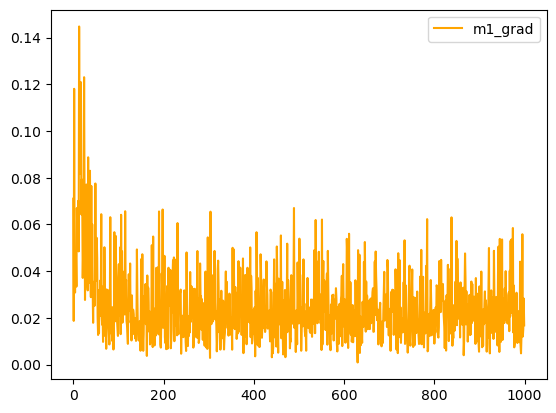

In [35]:
#plt.plot(np.arange(0,len(m1_loss)), np.array(m1_loss), label = "m1_loss", color = "blue")
plt.plot(np.arange(0,len(m1_grad)), m1_grad, label = "m1_grad", color = "orange")
plt.legend()
plt.show()

In [ ]:
# Define your neural network model here
# ... (replace with your model definition)

# Loss function (assuming it's already defined)
loss_fn = nn.MSELoss()  # Example, replace with your loss function

# Function to calculate the Hessian matrix
def compute_hessian(inputs, outputs):
    with torch.autograd.no_grad():
        loss = loss_fn(outputs, inputs)  # Note the order of inputs/outputs in loss_fn
    hessian = torch.autograd.functional.hessian(loss, model.parameters())
    return hessian

# Example input and output tensors
input_tensor = torch.randn(1, 784)  # Replace with your input shape
output_tensor = model(input_tensor)  # Assuming model output

# Calculate and analyze the Hessian
hessian = compute_hessian(input_tensor, output_tensor)
eigenvalues, _ = torch.linalg.eig(hessian)

# Calculate minimal ratio
minimal_ratio = torch.min(eigenvalues) / torch.max(eigenvalues)

# Print the results
print("Minimal ratio:", minimal_ratio.item())

# Further analysis (optional)
# - Visualize the eigenvalues distribution (histogram, etc.)
# - Track minimal ratio over training epochs
